In [29]:
import math
import random
import numpy as np
import pandas as pd

# Expected Damage on creature CR rating
# CR 0-3 : +5 to hit vs 13 AC requires an 8 or better; 65% to hit.
# CR 4 : (ASI) +6 to hit vs 14 AC requires an 8 or better; 65% to hit.
# CR 5-7 : (Proficiency +3) +7 to hit vs 15 AC requires an 8 or better; 65% to hit.
# CR 8 : (ASI to 20) +8 to hit vs 16 AC requires an 8 or better; 65% to hit.
# CR 9 : (Proficiency +4) +9 to hit vs 16 AC requires a 7 or better; 70% to hit.
# CR 10-12 : +9 to hit vs 17 AC requires an 8 or better; 65% to hit.
# CR 13-16 : (Proficiency +5) +10 to hit vs 18 AC requires an 8 or better; 65% to hit.
# CR 17+ : (Proficiency +6) +11 to hit vs 19 AC requires an 8 or better; 65% to hit.

def expected_damage(defender_AC=None, attack_modifier=None, expected_damage=None, bonus_damage=None, num_attacks=1, 
                    crit_added_damage=0, advantage_added_damage=0, crit_chance=0.05, crit_multiplier=2, 
                    advantage=False, disadvantage=False, level=None, **extra_args):
    
    if defender_AC is None:
        defender_AC = 10
        # estimate AC based on total level
        for arg in extra_args.keys():
            if '_lvl' in arg:
                defender_AC += extra_args[arg] 

    probability_hit = 1.0 - max(defender_AC -1 - attack_modifier, 0) / 20.0 

    if advantage and not disadvantage:
        probability_hit = 1.0 - (1 - probability_hit) ** 2
        crit_chance = 1.0 - (1 - crit_chance) ** 2
        expected_damage += advantage_added_damage
    elif disadvantage and not advantage:
        probability_hit = probability_hit ** 2
        crit_chance = crit_chance ** 2
    
    probability_hit_no_crit = max(0.0, probability_hit - crit_chance)
    
    crit_damage = (expected_damage + crit_added_damage) * crit_multiplier + bonus_damage
    non_crit_damage = expected_damage + bonus_damage
    expected_damage_per_hit = probability_hit_no_crit * non_crit_damage + crit_chance * crit_damage 

    results = {}
    results['probablity_hit'] = probability_hit
    results['crit_chance per round'] = crit_chance * num_attacks
    results['hit damage'] = non_crit_damage
    results['crit damage'] = crit_damage
    results['expected damage per hit'] = expected_damage_per_hit
    results['expected damage per round'] = expected_damage_per_hit * num_attacks
    return results



# Dice Roll
def dr(num_dice, num_sides):
    return num_dice * (num_sides + 1) / 2

In [30]:
is_health_low = False

hunters_mark = dr(1,6)
hex_curse = 0.1
smite = dr(2,8)

In [31]:
# using polearm master + duling style
records = []
for param in [dict(advantage=False, disadvantage=False), 
              dict(advantage=True, disadvantage=False), 
              dict(advantage=False, disadvantage=True)]:

    config = dict(
        name = 'PAM + Duling Style',
        paladin_lvl = 5,
        warlock_lvl = 0,
        attack_modifier = 5,
        expected_damage = dr(1,6),
        bonus_damage = 2+2,
        crit_added_damage = smite,
        num_attacks = 3,
        **param
    )
    records.append({**config, **expected_damage(**config)})

    config = dict(
        name = 'PAM + Duling Style',
        paladin_lvl = 6,
        warlock_lvl = 0,
        attack_modifier = 5,
        expected_damage = dr(1,6),
        bonus_damage = 2+2,
        crit_added_damage = smite,
        num_attacks = 3,
        **param
    )
    records.append({**config, **expected_damage(**config)})

    config = dict(
        name = 'PAM + Duling Style',
        paladin_lvl = 7,
        warlock_lvl = 0,
        attack_modifier = 5,
        expected_damage = dr(1,6),
        bonus_damage = 2+2+3,
        crit_added_damage = smite,
        num_attacks = 3,
        **param
    )
    records.append({**config, **expected_damage(**config)})

    config = dict(
        name = 'PAM + Duling Style',
        paladin_lvl = 8,
        warlock_lvl = 0,
        attack_modifier = 5,
        expected_damage = dr(1,6),
        bonus_damage = 2+2+4,
        crit_added_damage = smite,
        num_attacks = 3,
        **param
    )
    records.append({**config, **expected_damage(**config)})

    config = dict(
        name = 'PAM + Duling Style',
        paladin_lvl = 6,
        warlock_lvl = 1,
        attack_modifier = 6,
        expected_damage = dr(1,6) + dr(1,6),
        bonus_damage = 3+2,
        crit_added_damage = smite,
        num_attacks = 3,
        **param
    )
    records.append({**config, **expected_damage(**config)})

    config = dict(
        name = 'PAM + Duling Style\n+ Hexblade',
        paladin_lvl = 7,
        warlock_lvl = 1,
        attack_modifier = 6,
        expected_damage = dr(1,6) + dr(1,6),
        bonus_damage = 3+2+3,
        crit_added_damage = smite,
        num_attacks = 3,
        **param
    )
    records.append({**config, **expected_damage(**config)})
    
    config = dict(
        name = 'PAM + Duling Style\n+ Hexblade',
        paladin_lvl = 8,
        warlock_lvl = 1,
        attack_modifier = 7,
        expected_damage = dr(1,6) + dr(1,6),
        bonus_damage = 4+2+4,
        crit_added_damage = smite,
        num_attacks = 3,
        **param
    )
    records.append({**config, **expected_damage(**config)})

    config = dict(
        name = 'PAM + Duling Style\n+ Hexblade',
        paladin_lvl = 7,
        warlock_lvl = 2,
        attack_modifier = 6,
        expected_damage = dr(1,6) + dr(1,6),
        bonus_damage = 3+2+3,
        crit_added_damage = smite,
        num_attacks = 3,
        **param
    )
    records.append({**config, **expected_damage(**config)})

pam_records = records

In [32]:
# using teeth bite weapon + hunters mark (fey touched feat)
records = []
for param in [dict(advantage=False, disadvantage=False), 
              dict(advantage=True, disadvantage=False), 
              dict(advantage=False, disadvantage=True)]:
    
    config = dict(
        name = 'Teeth + hunters mark',
        paladin_lvl = 5,
        warlock_lvl = 0,
        attack_modifier = 7,
        expected_damage = dr(1,4) + dr(1,6),
        bonus_damage = 4,
        crit_added_damage = smite,
        num_attacks = 2,
        **param
    )
    records.append({**config, **expected_damage(**config)})

    config = dict(
        name = 'Teeth + hunters mark',
        paladin_lvl = 6,
        warlock_lvl = 0,
        attack_modifier = 7,
        expected_damage = dr(1,4) + dr(1,6),
        bonus_damage = 4,
        crit_added_damage = smite,
        num_attacks = 2,
        **param
    )
    records.append({**config, **expected_damage(**config)})

    config = dict(
        name = 'Teeth + hunters mark',
        paladin_lvl = 7,
        warlock_lvl = 0,
        attack_modifier = 7,
        expected_damage = dr(1,4) + dr(1,6),
        bonus_damage = 4+4,
        crit_added_damage = smite,
        num_attacks = 2,
        **param
    )
    records.append({**config, **expected_damage(**config)})
    
    config = dict(
        name = 'Teeth + hunters mark\n+ PAM',
        paladin_lvl = 8,
        warlock_lvl = 0,
        attack_modifier = 5,
        expected_damage = dr(1,4) + dr(1,6),
        bonus_damage = 2+2+2,
        crit_added_damage = smite,
        num_attacks = 3,
        **param
    )
    records.append({**config, **expected_damage(**config)})

teeth_fey_records = records

In [33]:
# teeth weapon + skill expert feat (non combat)
records = []

for param in [dict(advantage=False, disadvantage=False), 
              dict(advantage=True, disadvantage=False), 
              dict(advantage=False, disadvantage=True)]:

    config = dict(
        name = 'Teeth',
        paladin_lvl = 5,
        warlock_lvl = 0,
        attack_modifier = 7,
        expected_damage = dr(1,4),
        bonus_damage = 4,
        crit_added_damage = smite,
        num_attacks = 2,
        **param
    )
    records.append({**config, **expected_damage(**config)})
    
    config = dict(
        name = 'Teeth',
        paladin_lvl = 6,
        warlock_lvl = 0,
        attack_modifier = 7,
        expected_damage = dr(1,4),
        bonus_damage = 4,
        crit_added_damage = smite,
        num_attacks = 2,
        **param
    )

    records.append({**config, **expected_damage(**config)})

    config = dict(
        name = 'Teeth',
        paladin_lvl = 7,
        warlock_lvl = 0,
        attack_modifier = 7,
        expected_damage = dr(1,4),
        bonus_damage = 4+4,
        crit_added_damage = smite,
        num_attacks = 2,
        **param
    )
    records.append({**config, **expected_damage(**config)})

    config = dict(
        name = 'Teeth + hexblade',
        paladin_lvl = 6,
        warlock_lvl = 1,
        attack_modifier = 7,
        expected_damage = dr(1,4),
        bonus_damage = 4,
        crit_added_damage = smite,
        num_attacks = 2,
        **param
    )
    records.append({**config, **expected_damage(**config)})

teeth_records = records


,name,level,advantage,disadvantage,paladin_lvl,warlock_lvl,expected damage per round
12,PAM + Duling Style,5,False,False,5,0,15.60000
28,PAM + Duling Style,5,False,True,5,0,6.96750
20,PAM + Duling Style,5,True,False,5,0,24.23250
0,Teeth,5,False,False,5,0,10.50000
8,Teeth,5,False,True,5,0,5.59500
4,Teeth,5,True,False,5,0,15.40500
36,Teeth + hunters mark,5,False,False,5,0,15.40000
44,Teeth + hunters mark,5,False,True,5,0,8.57000
40,Teeth + hunters mark,5,True,False,5,0,22.23000
13,PAM + Duling Style,6,False,False,6,0,14.47500


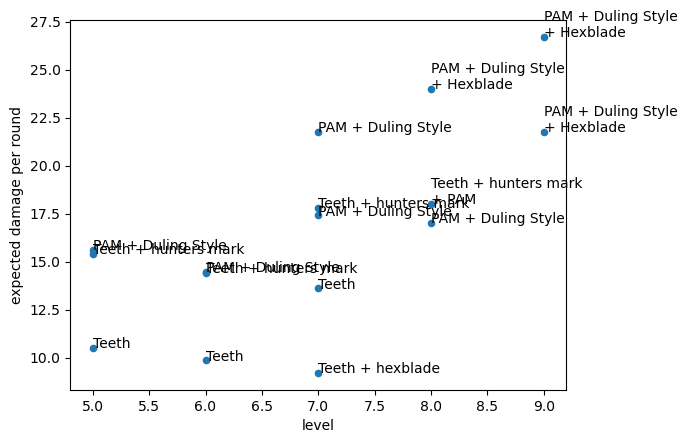

In [39]:

df = pd.DataFrame.from_records(teeth_records+pam_records+teeth_fey_records)
df['level'] = df.paladin_lvl + df.warlock_lvl

plot_df = df.query('advantage == False & disadvantage == False')
ax = plot_df.plot(x='level', y='expected damage per round', kind='scatter', )
for idx, row in plot_df.iterrows():
    ax.annotate(row['name'], (row['level'], row['expected damage per round']))

cols = ['name', 'level', 'advantage', 'disadvantage', 'paladin_lvl', 'warlock_lvl', 'expected damage per round']
df.sort_values(['level', 'paladin_lvl', 'warlock_lvl', 'name', 'advantage', 'disadvantage'])[cols]

In [40]:
df.query('disadvantage==True').sort_values(['level', 'paladin_lvl', 'warlock_lvl', 'name', 'advantage', 'disadvantage'])[cols]

,name,level,advantage,disadvantage,paladin_lvl,warlock_lvl,expected damage per round
28,PAM + Duling Style,5,False,True,5,0,6.96750
8,Teeth,5,False,True,5,0,5.59500
44,Teeth + hunters mark,5,False,True,5,0,8.57000
29,PAM + Duling Style,6,False,True,6,0,5.78625
9,Teeth,6,False,True,6,0,4.78250
45,Teeth + hunters mark,6,False,True,6,0,7.32000
32,PAM + Duling Style,7,False,True,6,1,9.18750
11,Teeth + hexblade,7,False,True,6,1,4.03500
30,PAM + Duling Style,7,False,True,7,0,6.54000
10,Teeth,7,False,True,7,0,6.45500
